In [4]:
#Here we are preprocessing all the anat and func data. 
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ,get_json_from_file

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob
from scipy.ndimage import zoom
import shutil


import ants
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json

from IPython.display import display, HTML



(ipykernel_launcher.py:448): Gdk-WARNING **: 08:44:36.816: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [32]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

In [6]:
#Import paths and creation of files for preprocessing
import subprocess
from fsl.wrappers import mcflirt

dataset_id = 'ds000171'
subject = '01'

subject_dir = 'sub-control{}'.format(subject)

sample_path = "/home/jovyan/data/dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(os.path.abspath(""),sample_path, dataset_id)

###################
# Create folders relevant for preprocessing.
# In BIDs, ANYTHING we modify must go in the derivatives folder, to keep original files clean in case we make a mistake.
###################

#Creating pre processed path
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(deriv_root)
#Path to the anatomical raw data
anatomical_path = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz')
bet_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w')
#Path to the functional raw data
fmap_path = op.join(bids_root, 'sub-control01', 'func')

# Import data :

In [19]:
# Import dataset
subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, # Openneuro has for each dataset a unique identifier
                "--target-dir", bids_root,  # The path where we want to save our data. You should save your data under /home/jovyan/Data/[your dataset ID] to be 100% fool-proof
                "--include", subject_dir # Effectively get all data
               ], check=True)



👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds000171 …
Cannot determine local revision of the dataset, and the target directory is not empty. If the download fails, you may want to try again with a fresh (empty) target directory.


📁 Traversing directories for ds000171 : 18 entities [00:08,  2.02 entities/s]


📥 Retrieving up to 15 files (5 concurrent downloads). 


dataset_description.json:   0%|          | 0.00/2.79k [00:00<?, ?B/s]
                                                                     
                                                                                    
sub-control01_T1w.nii.gz:   3%|▎         | 288k/8.77M [00:00<00:09, 898kB/s] 
sub-control01_task-music_run-1_bold.nii.gz:   0%|          | 0.00/33.8M [00:00<?, ?B/s]

sub-control01_task-music_run-3_bold.nii.gz:   0%|          | 0.00/33.9M [00:00<?, ?B/s]


sub-control01_task-music_run-2_bold.nii.gz:   0%|          | 0.00/33.9M [00:00<?, ?B/s]
sub-control01_task-music_run-1_bold.nii.gz:   0%|          | 83.6k/33.8M [00:00<01:15, 471kB/s]
sub-control01_T1w.nii.gz:  36%|███▌      | 3.16M/8.77M [00:00<00:00, 8.20MB/s]



sub-control01_task-music_run-3_events.tsv:   0%|          | 0.00/339 [00:00<?, ?B/s]



                                                                                    


sub-control01_task-music_run-2_bold.nii.gz:   0%|          | 83.6k/33.9M [00:

✅ Finished downloading ds000171.
 
🧠 Please enjoy your brains.
 


CompletedProcess(args=['openneuro-py', 'download', '--dataset', 'ds000171', '--target-dir', '/home/jovyan/data/dataset/ds000171', '--include', 'sub-control01'], returncode=0)

In [12]:
mkdir_no_exist(op.join(bids_root, 'derivatives'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'func'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'fmap'))




In [32]:
os.system('fsl_anat')

Usage: fsl_anat [options] -i <structural image>
       fsl_anat [options] -d <existing anat directory>
 
Arguments (You may specify one or more of):
  -i <strucural image>         filename of input image (for one image only)
  -d <anat dir>                directory name for existing .anat directory where this script will be run in place
  -o <output directory>        basename of directory for output (default is input image basename followed by .anat)
  --clobber                    if .anat directory exist (as specified by -o or default from -i) then delete it and make a new one
  --strongbias                 used for images with very strong bias fields
  --weakbias                   used for images with smoother, more typical, bias fields (default setting)
  --noreorient                 turn off step that does reorientation 2 standard (fslreorient2std)
  --nocrop                     turn off step that does automated cropping (robustfov)
  --nobias                     turn off steps tha

0

# Pre processing on anatomical data : 

In [35]:
def fsl_anat_wrapped(anatomical_target, output_path):
    os.system('fsl_anat -i {} --clobber --nosubcortseg -o {}'.format(anatomical_target,output_path))
    # Now move all files from the output_path.anat folder created by FSL to 
    # the actual output_path
    fsl_anat_path = output_path+'.anat'
    files_to_move = glob.glob(op.join(fsl_anat_path, '*'))
    for f in files_to_move:
        shutil.move(f, op.join(output_path, op.split(f)[1]))
    
    # Remove the output_path.anat folder
    os.rmdir(fsl_anat_path)

In [36]:
fsl_anat_wrapped(anatomical_path, op.join(preproc_root, 'sub-control01/anat'))

Mon Oct 21 10:15:11 UTC 2024
Reorienting to standard orientation
Mon Oct 21 10:15:17 UTC 2024
Automatically cropping the image
Starting Single Image Segmentation
T1-weighted image
Imagesize : 176 x 256 x 170
Pixelsize : 1.2 x 1 x 1

1 5.15907
2 5.58726
3 5.94017
KMeans Iteration 0
KMeans Iteration 1
KMeans Iteration 2
KMeans Iteration 3
KMeans Iteration 4
KMeans Iteration 5
KMeans Iteration 6
KMeans Iteration 7
KMeans Iteration 8
KMeans Iteration 9
KMeans Iteration 10
KMeans Iteration 11
KMeans Iteration 12
KMeans Iteration 13
KMeans Iteration 14
Tanaka Iteration 0 bias field 10
Tanaka-inner-loop-iteration=0 MRFWeightsTotal=2.0141e+07 beta=0.02
Tanaka-inner-loop-iteration=1 MRFWeightsTotal=2.04326e+07 beta=0.02
Tanaka-inner-loop-iteration=2 MRFWeightsTotal=2.04422e+07 beta=0.02
Tanaka-inner-loop-iteration=3 MRFWeightsTotal=2.04426e+07 beta=0.02
Tanaka-inner-loop-iteration=4 MRFWeightsTotal=2.04426e+07 beta=0.02
 CLASS 1 MEAN 100.155 STDDEV 131.718 CLASS 2 MEAN 257.478 STDDEV 69.432 CLA

# Pre processing on functional data : Motion correction

In [14]:
#Use glob to find all relevant BOLD files dynamically (e.g., for 'task-music' runs)
func_dir = os.path.join(bids_root, f'sub-control{subject}/func')
bold_files = sorted(glob.glob(os.path.join(func_dir, f'sub-control{subject}_task-music_run-*_bold.nii.gz')))
# Define the white matter segmentation path
white_matter_segmentation = op.join(preproc_root, f'sub-control{subject}', 'anat', 'T1_fast_pve_2.nii.gz')


# Check if any files were found
if not bold_files:
    raise FileNotFoundError(f"No task-music BOLD runs found for subject {subject}.")

# Process each BOLD file
for bold_file in bold_files:
    # Extract the run identifier (e.g., run-1, run-2) from the file path
    run_id = bold_file.split('_')[-2]  # Extracts 'run-1', 'run-2', etc.

    # Create the path for motion-corrected output
    path_moco_data = os.path.join(preproc_root, f'sub-control{subject}/func', f'sub-control{subject}_task-music_{run_id}_bold_moco')
    path_original_data = os.path.join(bids_root, f'sub-control{subject}/func', f'sub-control{subject}_task-music_{run_id}_bold.nii.gz')
    
    # Print or use these paths in the rest of your processing pipeline
    print(f'Original Data Path: {bold_file}')
    print(f'Motion Corrected Data Path: {path_moco_data}')
    
    # Now you can add your processing steps (e.g., motion correction, smoothing) here
    # motion correction (using FSL's mcflirt):
    #os.system(f'mcflirt -in {bold_file} -out {path_moco_data} -refvol 0 -plots')
    mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

    # Path to the motion parameters file generated by mcflirt
    mot_params_path = os.path.join(preproc_root, f'sub-control{subject}/func', f'sub-control{subject}_task-music_{run_id}_bold_moco.par')


    
   




Original Data Path: /home/jovyan/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-1_bold.nii.gz
Motion Corrected Data Path: /home/jovyan/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco


Processed data will be saved as /home/jovyan/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [52] to 8 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm scaling
Rescaling reference volume [52] to 4 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87]

refnum = 52
Original_refvol = -1


Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 


Original Data Path: /home/jovyan/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-2_bold.nii.gz
Motion Corrected Data Path: /home/jovyan/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-2_bold_moco


Processed data will be saved as /home/jovyan/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-2_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [52] to 8 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm scaling
Rescaling reference volume [52] to 4 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87]

refnum = 52
Original_refvol = -1


Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 


Original Data Path: /home/jovyan/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-3_bold.nii.gz
Motion Corrected Data Path: /home/jovyan/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-3_bold_moco


Processed data will be saved as /home/jovyan/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-3_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [52] to 8 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm scaling
Rescaling reference volume [52] to 4 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87]

refnum = 52
Original_refvol = -1


Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 


# Concatenation of run 1, 2, 3 together : 

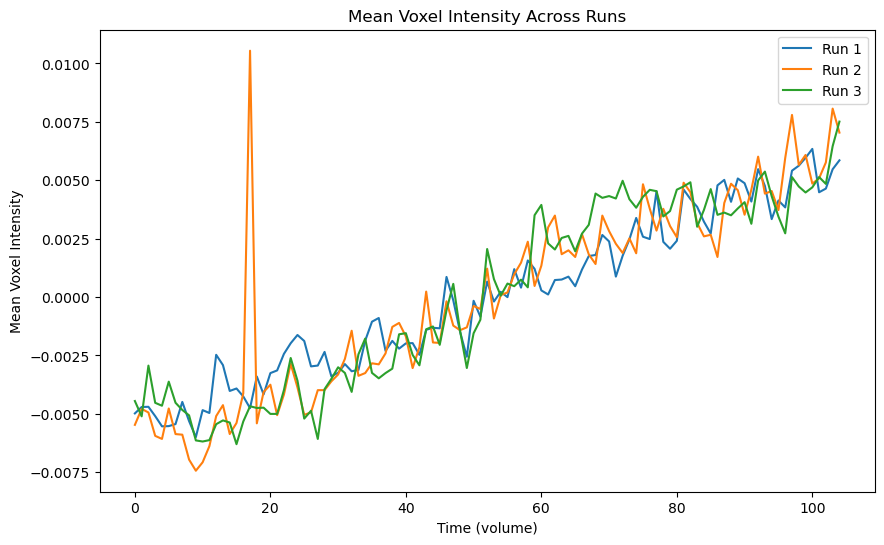

In [15]:
#Concatenation of run1,2,3 
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

def normalize_img(img_data):
    """
    Normalize the image data to the MNI template.
    This function assumes a simple linear normalization.
    """
    # Find the mean and standard deviation of the image
    mean = img_data.mean()
    std = img_data.std()

    # Normalize the image data (z-score normalization)
    normalized_data = (img_data - mean) / std
    return normalized_data

def concatenate_runs(run_files):
    """
    Normalize and concatenate multiple 4D fMRI runs.
    
    Parameters:
    run_files (list of str): List of file paths to the NIfTI files.
    
    Returns:
    nibabel.Nifti1Image: A new NIfTI image object with concatenated runs.
    """
    normalized_runs = []
    plt.figure(figsize=(10, 6))
    
    for run_file in run_files:
        # Load the NIfTI file
        img = nib.load(run_file)
        img_data = img.get_fdata()

        # Normalize the image (assuming the data is 4D)
        normalized_data = normalize_img(img_data)
        normalized_runs.append(normalized_data)
        
        mean_voxel_intensity = normalized_data.mean(axis=(0, 1, 2))
        # Plot the mean voxel intensity for this run
        plt.plot(mean_voxel_intensity, label=f'Run {run_files.index(run_file) + 1}')

    
     # Customize plot
    plt.xlabel('Time (volume)')
    plt.ylabel('Mean Voxel Intensity')
    plt.legend()
    plt.title('Mean Voxel Intensity Across Runs')
    plt.show()    
    # Concatenate runs along the 4th dimension (time)
    concatenated_data = np.concatenate(normalized_runs, axis=-1)

    # Create a new NIfTI image for the concatenated data
    new_img = nib.Nifti1Image(concatenated_data, img.affine, img.header)

    return new_img

# Example usage
moco_files = sorted(glob.glob(os.path.join(preproc_root, f'sub-control{subject}/func', f'sub-control{subject}_task-music_run-*_bold_moco.nii.gz')))

concatenated_image = concatenate_runs(moco_files)

# Save the concatenated image
nib.save(concatenated_image, os.path.join(preproc_root, 'sub-control01', 'func', 'concat.nii.gz'))

# Here we can see that voxel 17 and 18 of run 2 are problematic, hence we decided to remove them. Here is the code for the Mean voexel intensity without problematic voxels : 

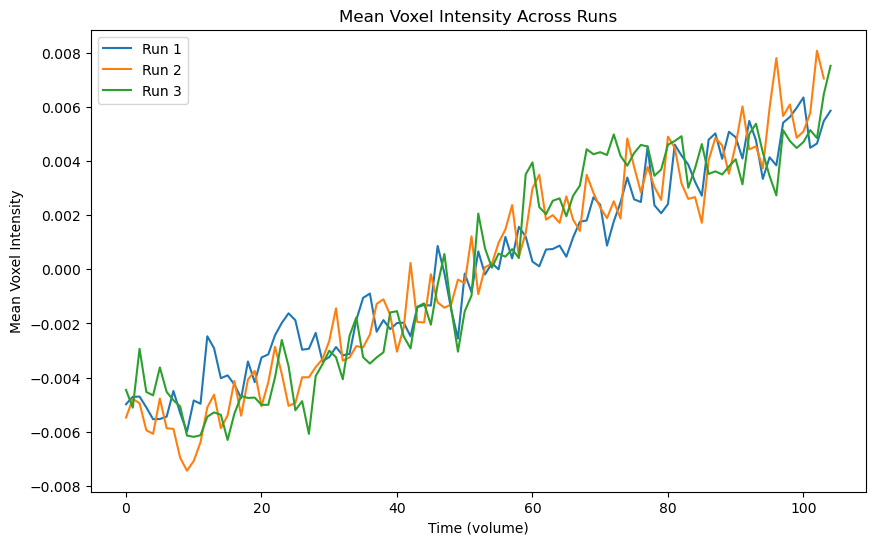

In [16]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

def normalize_img(img_data):
    mean = img_data.mean()
    std = img_data.std()
    normalized_data = (img_data - mean) / std
    return normalized_data

def concatenate_runs(run_files):
    """
    Normalize and concatenate multiple 4D fMRI runs.
    
    Parameters:
    run_files (list of str): List of file paths to the NIfTI files.
    
    Returns:
    nibabel.Nifti1Image: A new NIfTI image object with concatenated runs.
    """
    normalized_runs = []
    plt.figure(figsize=(10, 6))
    
    for idx, run_file in enumerate(run_files):
        # Load the NIfTI file
        img = nib.load(run_file)
        img_data = img.get_fdata()

        # Normalize the image (assuming the data is 4D)
        normalized_data = normalize_img(img_data)

        # Remove volumes 17 to 18 for run 2
        if idx == 1:  # Check if it's the second run
            normalized_data = np.delete(normalized_data, slice(17,18), axis=-1)

        normalized_runs.append(normalized_data)

        # Calculate the mean voxel intensity over the spatial dimensions for this run
        mean_voxel_intensity = normalized_data.mean(axis=(0, 1, 2))
        
        # Plot the mean voxel intensity for this run
        plt.plot(mean_voxel_intensity, label=f'Run {idx + 1}')

    # Customize plot
    plt.xlabel('Time (volume)')
    plt.ylabel('Mean Voxel Intensity')
    plt.legend()
    plt.title('Mean Voxel Intensity Across Runs')
    plt.show()
    
    # Concatenate runs along the 4th dimension (time)
    concatenated_data = np.concatenate(normalized_runs, axis=-1)

    # Create a new NIfTI image for the concatenated data
    new_img = nib.Nifti1Image(concatenated_data, img.affine, img.header)

    return new_img

# Example usage
moco_files = sorted(glob.glob(os.path.join(preproc_root, f'sub-control{subject}/func', f'sub-control{subject}_task-music_run-*_bold_moco.nii.gz')))

concatenated_image = concatenate_runs(moco_files)

# Save the concatenated image
nib.save(concatenated_image, os.path.join(preproc_root, 'sub-control01', 'func', 'concat.nii.gz'))


## Motion correction on concat cleaned data

In [19]:

# Create the path for motion-corrected output
path_moco_data = os.path.join(preproc_root, f'sub-control{subject}/func', f'sub-control{subject}_task-music_concat_bold_moco')
path_original_data = os.path.join(preproc_root, f'sub-control{subject}/func', 'concat.nii.gz')

mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

# Path to the motion parameters file generated by mcflirt
mot_params_path = os.path.join(preproc_root, f'sub-control{subject}/func', f'sub-control{subject}_task-music_concat_bold_moco.par')


Processed data will be saved as /home/jovyan/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concat_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289]

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][118][

In [21]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(mot_params_path)
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.003301,0.002548,0.000099,-0.049931,-0.444168,-0.468327
1,-0.003467,0.002548,0.000048,-0.060955,-0.441500,-0.470638
2,-0.002632,0.002628,0.000264,-0.044274,-0.422386,-0.467296
3,-0.002979,0.002744,-0.000009,-0.059486,-0.426123,-0.480432
4,-0.003102,0.002917,0.000116,-0.062463,-0.431160,-0.471252
...,...,...,...,...,...,...
309,0.009270,-0.000832,-0.001355,-0.083560,0.250018,0.057890
310,0.009463,-0.001240,-0.001355,-0.074648,0.242229,0.052208
311,0.009594,-0.000986,-0.001500,-0.081569,0.260777,0.041766
312,0.009581,-0.000783,-0.001517,-0.090935,0.248113,0.045579


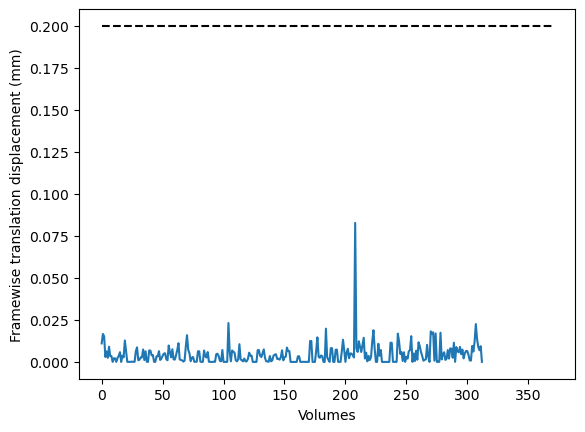

In [22]:
#Looking at the frame wise translation displacement : 

# Getting the translation is easy
trans_x = mot_params["Translation x"]
# Now, we want a 0.2mm with respect to previous frame:
disp_x = np.diff(trans_x)
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.2
plt.plot(np.abs(disp_x))
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()


In [23]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

In [24]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

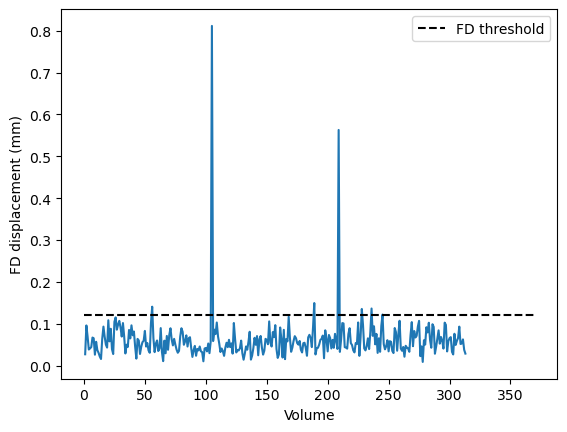

In [25]:
#%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [26]:
np.where(fd > threshold)[0] + 1

array([ 56, 105, 189, 209, 228, 236, 245])

In [31]:
#Deleting voxels above threshold : 
concat_path = os.path.join(preproc_root, 'sub-control01', 'func', 'concat.nii.gz')
img = nib.load(concat_path)
img_data = img.get_fdata()

img_data = np.delete(img_data, [56, 105, 189, 209, 228, 236, 245], axis=-1)
# Create a new NIfTI image for the concatenated data
new_img = nib.Nifti1Image(img_data, img.affine, img.header)

# Save the new image
nib.save(new_img, os.path.join(preproc_root, 'sub-control01', 'func', 'concat_fd_corrected.nii.gz'))


In [33]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(os.path.join(preproc_root, 'sub-control01', 'func', 'concat_fd_corrected.nii.gz'))



(ipykernel_launcher.py:448): Gdk-WARNING **: 09:24:00.989: gdkdrawable-x11.c:952 drawable is not a pixmap or window


# Pre processing on func data : Smoothing concatenated data : 

In [34]:
#Smoothing on concat data
concat_path = os.path.join(preproc_root, 'sub-control01', 'func', 'concat_fd_corrected.nii.gz')
cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(concat_path, 6/2.3548, concat_path)
subprocess.run(['fslmaths',concat_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(concat_path)])

CompletedProcess(args=['fslmaths', '/home/jovyan/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concat_fd_corrected.nii.gz', '-s', '2.547987090198743', '/home/jovyan/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concat_fd_corrected.nii.gz_smoothed-6mm'], returncode=0)

In [35]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(os.path.join(preproc_root, 'sub-control01', 'func', 'concat_fd_corrected.nii.gz_smoothed-6mm.nii.gz'))

